<a href="https://colab.research.google.com/github/StillWork/c9/blob/master/gg_66_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8_%E1%84%8F%E1%85%B3%E1%86%AF%E1%84%85%E1%85%A5%E1%84%89%E1%85%B3%E1%84%90%E1%85%A5%E1%84%85%E1%85%B5%E1%86%BC_410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 사람의 동작을 스마트폰의 가속도 센서 데이터로 분류하는 예

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.utils import np_utils

Using TensorFlow backend.


## 여섯개의 레이블을 사용한다.
- Downstairs, Jogging, Sitting, Standing, Upstairs, Walking


In [0]:
# 소수점 세 자리만 표시
pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(precision=3)

LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [11]:
import os, os.path, shutil
if not os.path.exists("./data"):
    os.makedirs("./data")
!curl http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz \
 -o ./data/WISDM_ar_latest.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0  15.6M      0 --:--:-- --:--:-- --:--:-- 15.6M


In [0]:
fname = './data/WISDM_ar_latest.tar.gz'

import tarfile
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('./data')
    tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open(fname, "r:")
    tar.extractall('./data')
    tar.close()

In [13]:
!head -5 ./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


In [0]:
def read_data(file_path):
    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # 마지막 컬럼에서 ";"를 삭제
  
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # 모두 소수로 변환 (현재 문자열로 바뀌어 있음)
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # 결측치 처리
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
 

df = read_data('./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [16]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.695,12.681,0.504
1,33,Jogging,49106062271000,5.012,11.264,0.953
2,33,Jogging,49106112167000,4.903,10.883,-0.082
3,33,Jogging,49106222305000,-0.613,18.496,3.024
4,33,Jogging,49106332290000,-1.185,12.108,7.205


In [17]:
df.shape

(1098203, 6)

In [18]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

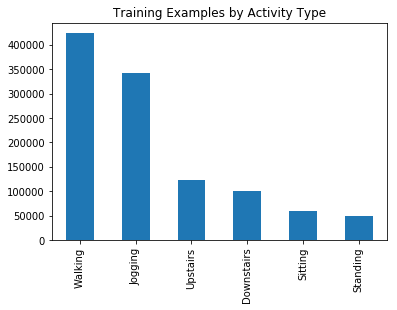

In [19]:
df['activity'].value_counts().plot(kind='bar',
                              title='Training Examples by Activity Type')
plt.show()

In [20]:
# 시각이 0이거나 음수인 샘플은 제외
df = df[df['timestamp'] > 0]
df.shape

(1085360, 6)

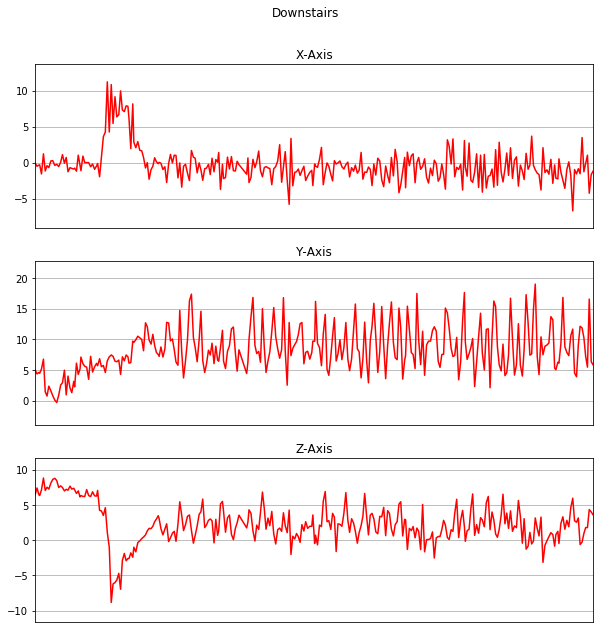

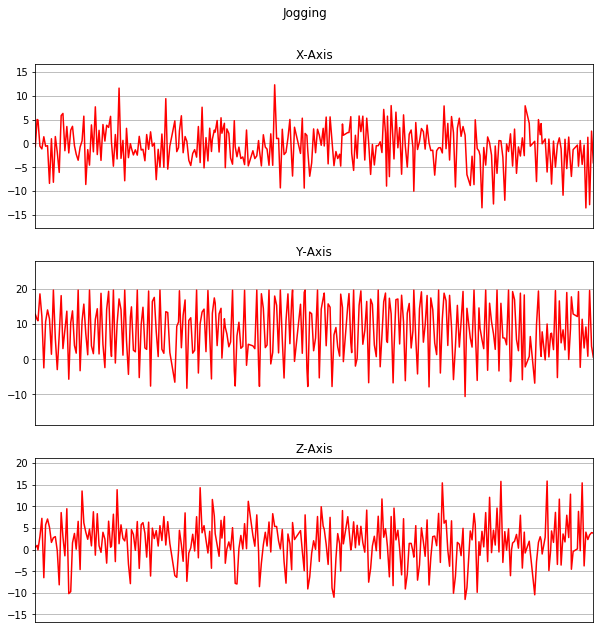

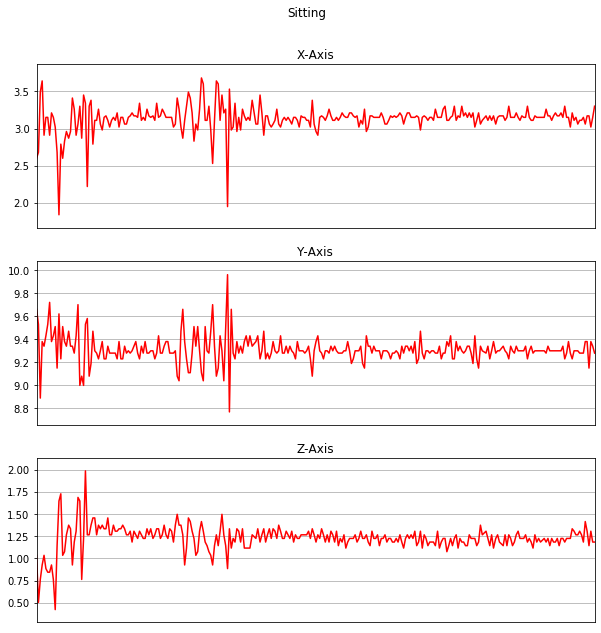

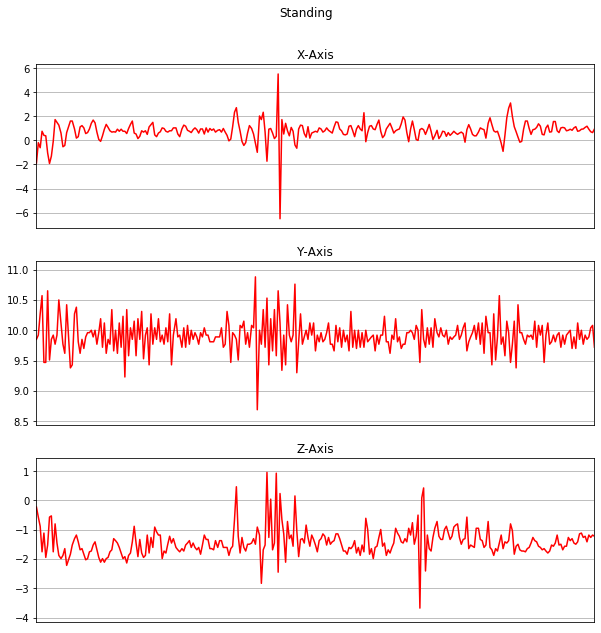

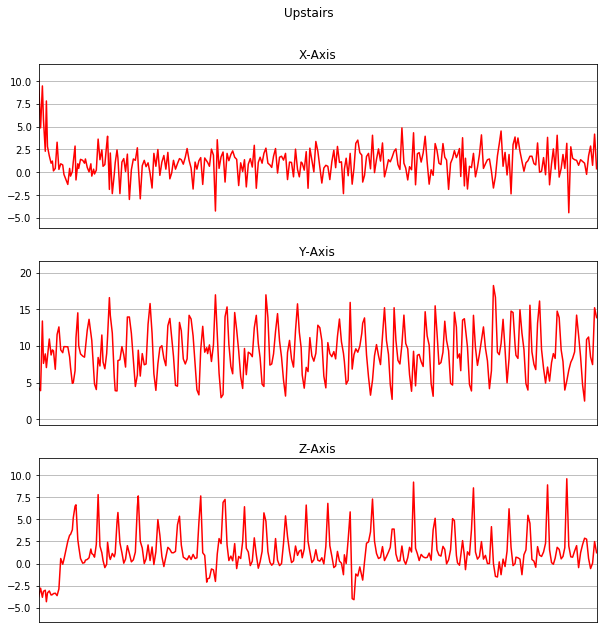

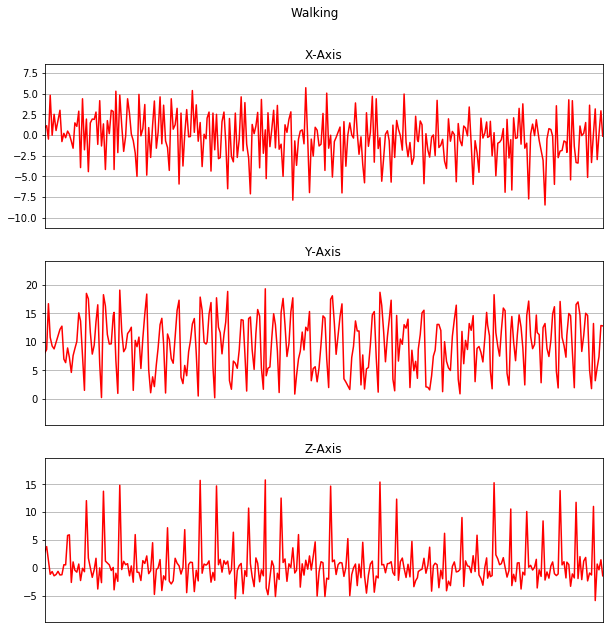

In [21]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:300]
    plot_activity(activity, subset)

In [0]:
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [23]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.695,12.681,0.504,1
1,33,Jogging,49106062271000,5.012,11.264,0.953,1
2,33,Jogging,49106112167000,4.903,10.883,-0.082,1
3,33,Jogging,49106222305000,-0.613,18.496,3.024,1
4,33,Jogging,49106332290000,-1.185,12.108,7.205,1


In [24]:
df['activity'].value_counts()

Walking       423905
Jogging       330330
Upstairs      122598
Downstairs    100194
Sitting        59939
Standing       48394
Name: activity, dtype: int64

In [34]:
test = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4]
stats.mode(test)

ModeResult(mode=array([3]), count=array([15]))

In [35]:
z = stats.mode(df['act'][0:100])
z[0][0], z[1][0]

(1, 100)

In [30]:
df.columns

Index(['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis',
       'act'],
      dtype='object')

In [0]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [32]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198,0.792,0.018,1
1,33,Jogging,49106062271000,0.630,0.582,0.112,1
2,33,Jogging,49106112167000,0.614,0.525,-0.104,1
3,33,Jogging,49106222305000,-0.186,1.655,0.545,1
4,33,Jogging,49106332290000,-0.269,0.707,1.420,1


In [0]:
# N개 샘플씩 끊어서 유효한 (통일된) 동작 레이블을 찾는다 
N = 100
X_all = []
y = []
for i in range(0, len(df)-N+1, N):
    z = stats.mode(df['act'][i: i+N])
    action, count = z[0][0], z[1][0]
    if count == N:
        xs = df['x-axis'].values[i: i + N]
        ys = df['y-axis'].values[i: i + N]
        zs = df['z-axis'].values[i: i + N]
        X_all.append([xs, ys, zs])
        y.append(action)

    # Bring the segments into a better shape

X_all = np.asarray(X_all, dtype= np.float32)
y = np.asarray(y)

In [0]:
X_all.shape

(10469, 3, 100)

In [0]:
X_3 = np.transpose(X_all, (0,2,1))

In [0]:
X_3.shape

(10469, 100, 3)

In [0]:
# z-axis 성분만 추출
X = X_3[:,:,2]
X[0]

array([ 0.018,  0.112, -0.104,  0.545,  1.42 , -1.448,  1.106,  1.388,
        0.987,  0.258,  0.483,  0.537, -0.15 , -1.793,  1.699,  0.523,
       -0.392,  1.884, -2.217, -2.121,  0.235,  0.691, -0.07 ,  1.275,
       -1.055,  2.741,  1.203,  0.753,  0.409,  0.899,  0.09 ,  1.739,
       -0.36 ,  1.645,  0.098, -0.224,  0.748,  0.417, -0.745,  1.283,
        0.024,  0.073,  1.619, -0.671,  2.804,  0.192,  1.106,  0.448,
        0.329,  0.89 , -0.785, -1.736,  0.876,  0.642, -0.127,  1.266,
       -1.001,  1.115,  1.212,  0.705, -0.454,  1.235, -1.369,  0.947,
        0.443,  0.827,  0.081,  1.067,  0.346,  1.508,  0.129,  1.26 ,
        0.209, -1.346, -1.431, -0.144,  0.842,  0.152, -0.657,  1.685,
       -1.625, -0.255, -0.007,  0.651, -0.158,  1.5  , -0.489,  2.901,
        0.722,  1.067,  0.377, -0.255,  0.793, -0.993,  2.331,  1.531,
        0.682,  0.121, -0.415,  1.323], dtype=float32)

In [0]:
X.shape, y.shape

((10469, 100), (10469,))

In [0]:
# LABELS

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [0]:
# classes = len(df['act'].unique())

In [0]:
y_hot = np_utils.to_categorical(y)
y_hot.shape

(10469, 6)

In [0]:
y_hot[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline

/Users/hwa-jongkim/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size = 0.2)
rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.6341929321872015

In [0]:
X_train.shape, y_train.shape

((8375, 100), (8375, 6))

In [0]:
model_m = Sequential()
model_m.add(Dense(100, activation='relu', input_shape=(100,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 606       
Total params: 20,806
Trainable params: 20,806
Non-trainable params: 0
_________________________________________________________________
None


## 동작 환경 설정
- 조기 종료 (2회 동안 개선되지 않으면 종료)
- 배키 크기 400
- 이포크 50
- 훈련데이터: 검증 데이터 = 8:2


In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 10
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 1s 218us/step - loss: 0.9022 - acc: 0.6552 - val_loss: 0.6772 - val_acc: 0.7564
Epoch 2/30
6700/6700 [==============================] - 1s 165us/step - loss: 0.5454 - acc: 0.8088 - val_loss: 0.5889 - val_acc: 0.7976
Epoch 3/30
6700/6700 [==============================] - 1s 176us/step - loss: 0.4240 - acc: 0.8470 - val_loss: 0.5598 - val_acc: 0.7922
Epoch 4/30
6700/6700 [==============================] - 1s 176us/step - loss: 0.3425 - acc: 0.8772 - val_loss: 0.5750 - val_acc: 0.8060
Epoch 5/30
6700/6700 [==============================] - 1s 165us/step - loss: 0.2876 - acc: 0.8952 - val_loss: 0.5652 - val_acc: 0.8161
Epoch 6/30
6700/6700 [==============================] - 1s 164us/step - loss: 0.2345 - acc: 0.9142 - val_loss: 0.6248 - val_acc: 0.8185
Epoch 7/30
6700/6700 [==============================] - 1s 166us/step - loss: 0.1959 - acc: 0.9297 - val_loss: 0.6249 - val_acc: 0.8155


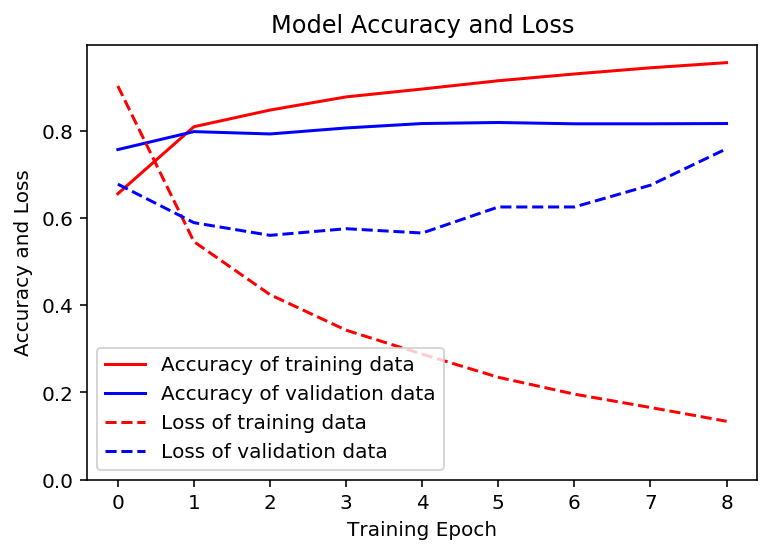

In [0]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [0]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

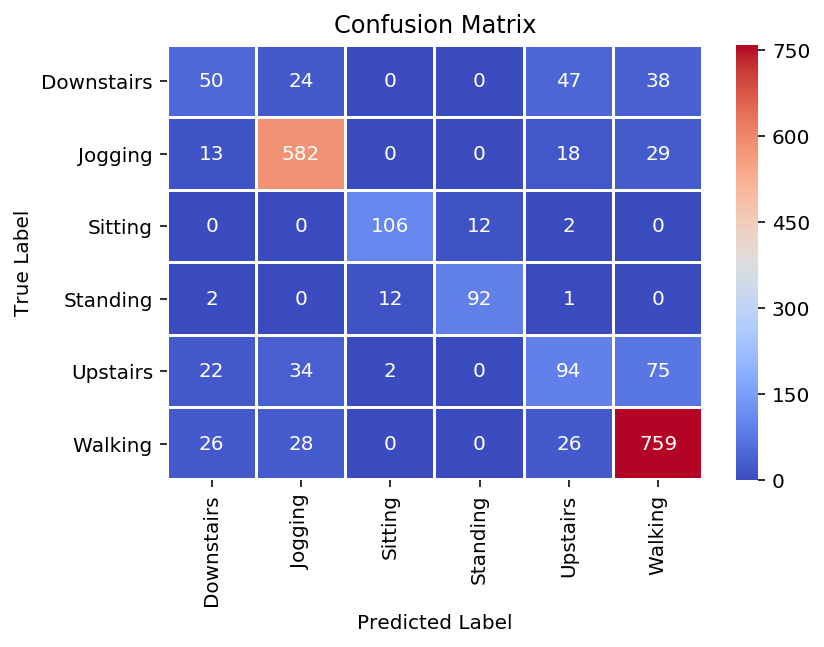

             precision    recall  f1-score   support

          0       0.44      0.31      0.37       159
          1       0.87      0.91      0.89       642
          2       0.88      0.88      0.88       120
          3       0.88      0.86      0.87       107
          4       0.50      0.41      0.45       227
          5       0.84      0.90      0.87       839

avg / total       0.79      0.80      0.79      2094



In [0]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

## CNN을 사용하여 성능을 개선

In [0]:
model_m = Sequential()
model_m.add(Reshape((N, 1), input_shape=(N,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(N,1)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 91, 100)           1100      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 82, 100)           100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 100)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 18, 160)           160160    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 160)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 160)               0         
__________

In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 14s 2ms/step - loss: 0.7438 - acc: 0.7103 - val_loss: 0.4646 - val_acc: 0.8149
Epoch 2/30
6700/6700 [==============================] - 14s 2ms/step - loss: 0.4273 - acc: 0.8412 - val_loss: 0.3299 - val_acc: 0.8806
Epoch 3/30
6700/6700 [==============================] - 14s 2ms/step - loss: 0.3467 - acc: 0.8712 - val_loss: 0.2911 - val_acc: 0.8949
Epoch 4/30
6700/6700 [==============================] - 14s 2ms/step - loss: 0.2885 - acc: 0.8922 - val_loss: 0.2746 - val_acc: 0.9063
Epoch 5/30
6700/6700 [==============================] - 14s 2ms/step - loss: 0.2582 - acc: 0.9007 - val_loss: 0.3078 - val_acc: 0.8907
Epoch 6/30
6700/6700 [==============================] - 15s 2ms/step - loss: 0.2203 - acc: 0.9137 - val_loss: 0.2487 - val_acc: 0.9152
Epoch 7/30
6700/6700 [==============================] - 17s 3ms/step - loss: 0.1968 - acc: 0.9243 - val_loss: 0.2562 - val_acc: 0.9104
Epoch 8

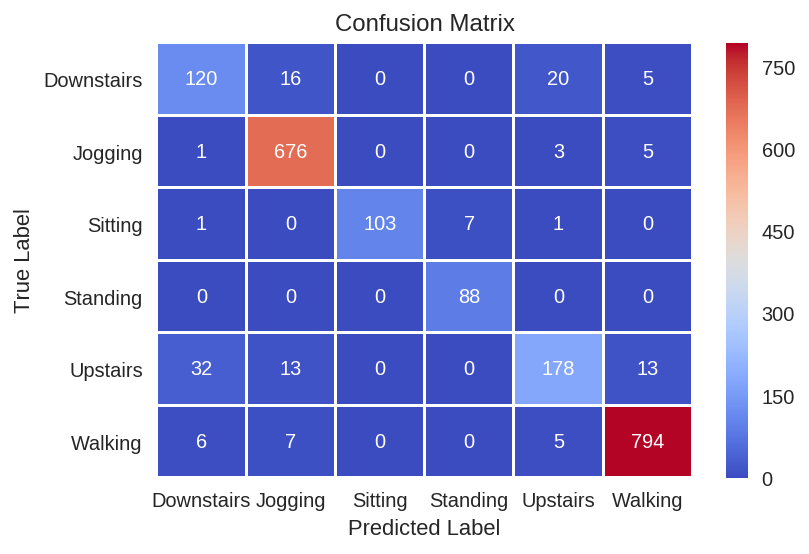

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       161
           1       0.95      0.99      0.97       685
           2       1.00      0.92      0.96       112
           3       0.93      1.00      0.96        88
           4       0.86      0.75      0.80       236
           5       0.97      0.98      0.97       812

   micro avg       0.94      0.94      0.94      2094
   macro avg       0.91      0.90      0.90      2094
weighted avg       0.93      0.94      0.93      2094



In [0]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# RNN으로 학습

In [0]:
from keras.layers import GRU
model = Sequential()
model.add(Reshape((N,1), input_shape=(N,)))
model.add(GRU(256, return_sequences=True, input_shape=(N,1)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(classes, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 100, 256)          198144    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 593,670
Trainable params: 593,670
Non-trainable params: 0
_________________________________________________________________


Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 121s 18ms/step - loss: 0.9903 - acc: 0.6169 - val_loss: 0.6896 - val_acc: 0.7469
Epoch 2/30
6700/6700 [==============================] - 120s 18ms/step - loss: 0.5601 - acc: 0.7919 - val_loss: 0.3438 - val_acc: 0.8746
Epoch 3/30
6700/6700 [==============================] - 120s 18ms/step - loss: 0.4258 - acc: 0.8442 - val_loss: 0.4501 - val_acc: 0.8466
Epoch 4/30
6700/6700 [==============================] - 119s 18ms/step - loss: 0.3476 - acc: 0.8742 - val_loss: 0.3209 - val_acc: 0.8860
Epoch 5/30
6700/6700 [==============================] - 119s 18ms/step - loss: 0.3004 - acc: 0.8907 - val_loss: 0.2327 - val_acc: 0.9194
Epoch 6/30
6700/6700 [==============================] - 120s 18ms/step - loss: 0.2663 - acc: 0.9027 - val_loss: 0.2291 - val_acc: 0.9164
Epoch 7/30
6700/6700 [==============================] - 120s 18ms/step - loss: 0.2233 - acc: 0.9201 - val_loss: 0.2760 - val_acc: 

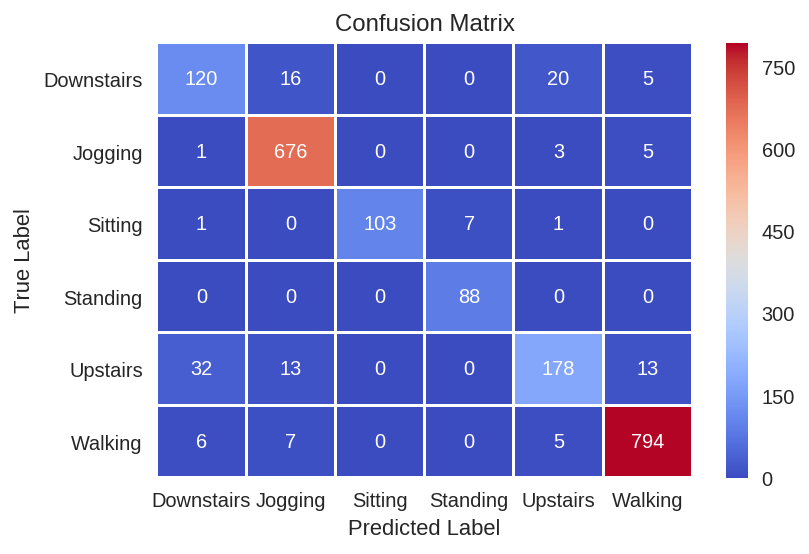

              precision    recall  f1-score   support

           0       0.75      0.75      0.75       161
           1       0.95      0.99      0.97       685
           2       1.00      0.92      0.96       112
           3       0.93      1.00      0.96        88
           4       0.86      0.75      0.80       236
           5       0.97      0.98      0.97       812

   micro avg       0.94      0.94      0.94      2094
   macro avg       0.91      0.90      0.90      2094
weighted avg       0.93      0.94      0.93      2094



In [0]:
history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# x,y,z 모두 사용할 때(Conv1D)

In [0]:
X_3.shape

(10469, 100, 3)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y_hot, test_size = 0.2)

model_m = Sequential()
model_m.add(Conv1D(64, 10, activation='relu',input_shape=(N,3)))
model_m.add(Conv1D(64, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(128, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(6, activation='softmax'))
# print(model_m.summary())

In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 20
EPOCHS = 30

history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 8s 1ms/step - loss: 0.6012 - acc: 0.7810 - val_loss: 0.3214 - val_acc: 0.8782
Epoch 2/30
6700/6700 [==============================] - 3s 407us/step - loss: 0.2739 - acc: 0.9028 - val_loss: 0.1613 - val_acc: 0.9558
Epoch 3/30
6700/6700 [==============================] - 3s 408us/step - loss: 0.1696 - acc: 0.9425 - val_loss: 0.1454 - val_acc: 0.9546
Epoch 4/30
6700/6700 [==============================] - 3s 405us/step - loss: 0.1324 - acc: 0.9566 - val_loss: 0.1040 - val_acc: 0.9666
Epoch 5/30
6700/6700 [==============================] - 3s 408us/step - loss: 0.0954 - acc: 0.9701 - val_loss: 0.0905 - val_acc: 0.9719
Epoch 6/30
6700/6700 [==============================] - 3s 408us/step - loss: 0.0862 - acc: 0.9737 - val_loss: 0.0872 - val_acc: 0.9719
Epoch 7/30
6700/6700 [==============================] - 3s 408us/step - loss: 0.0638 - acc

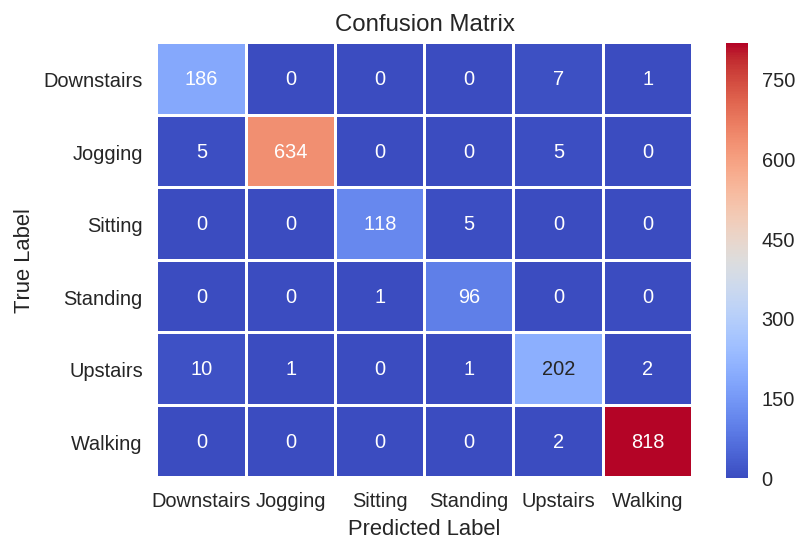

              precision    recall  f1-score   support

           0       0.93      0.96      0.94       194
           1       1.00      0.98      0.99       644
           2       0.99      0.96      0.98       123
           3       0.94      0.99      0.96        97
           4       0.94      0.94      0.94       216
           5       1.00      1.00      1.00       820

   micro avg       0.98      0.98      0.98      2094
   macro avg       0.96      0.97      0.97      2094
weighted avg       0.98      0.98      0.98      2094



In [0]:
y_pred_test = model_m.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))

# x,y,z, RNN

In [0]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(256, return_sequences=True, input_shape=(N,3)))
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(Dropout(0.2))
model.add(Dense(classes, activation='softmax'))

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)
]
model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 100, 256)          199680    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 1542      
Total params: 595,206
Trainable params: 595,206
Non-trainable params: 0
_________________________________________________________________


Train on 6700 samples, validate on 1675 samples
Epoch 1/30
6700/6700 [==============================] - 118s 18ms/step - loss: 0.7806 - acc: 0.7310 - val_loss: 0.5711 - val_acc: 0.8275
Epoch 2/30
6700/6700 [==============================] - 117s 17ms/step - loss: 0.3364 - acc: 0.8785 - val_loss: 0.2413 - val_acc: 0.9170
Epoch 3/30
6700/6700 [==============================] - 117s 17ms/step - loss: 0.1986 - acc: 0.9337 - val_loss: 0.2065 - val_acc: 0.9325
Epoch 4/30
6700/6700 [==============================] - 116s 17ms/step - loss: 0.1323 - acc: 0.9570 - val_loss: 0.1035 - val_acc: 0.9588
Epoch 5/30
6700/6700 [==============================] - 116s 17ms/step - loss: 0.0894 - acc: 0.9706 - val_loss: 0.1332 - val_acc: 0.9534
Epoch 6/30
6700/6700 [==============================] - 116s 17ms/step - loss: 0.0802 - acc: 0.9728 - val_loss: 0.1753 - val_acc: 0.9534
Epoch 7/30
6700/6700 [==============================] - 117s 17ms/step - loss: 0.0495 - acc: 0.9819 - val_loss: 0.0728 - val_acc: 

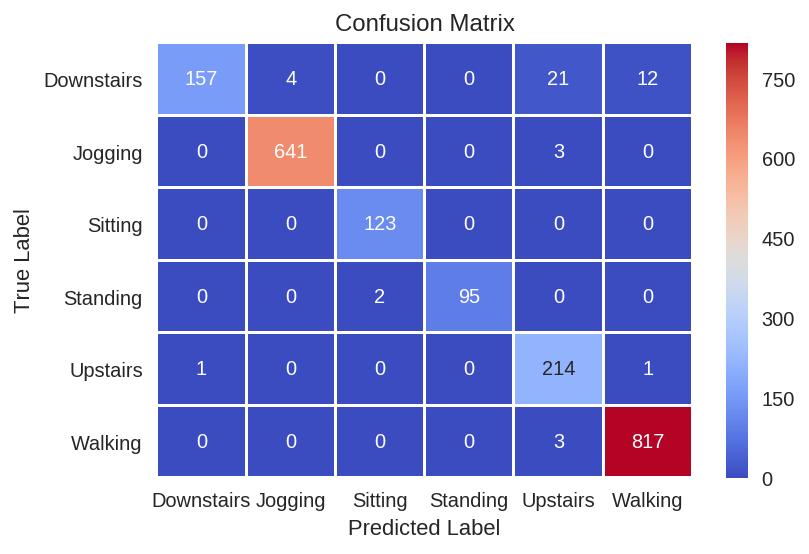

              precision    recall  f1-score   support

           0       0.99      0.81      0.89       194
           1       0.99      1.00      0.99       644
           2       0.98      1.00      0.99       123
           3       1.00      0.98      0.99        97
           4       0.89      0.99      0.94       216
           5       0.98      1.00      0.99       820

   micro avg       0.98      0.98      0.98      2094
   macro avg       0.97      0.96      0.97      2094
weighted avg       0.98      0.98      0.98      2094



In [0]:
history = model.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

y_pred_test = model.predict(X_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)
show_confusion_matrix(max_y_test, max_y_pred_test)
print(classification_report(max_y_test, max_y_pred_test))